In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pytz import timezone
import seaborn as sns

In [2]:
# 1. CSV-Daten laden
file_path = "../data/processed/charging_sessions_cleaned.csv"
df = pd.read_csv(file_path, parse_dates=["connectionTime", "disconnectTime"])
df.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,stationID,timezone,userID,userInputs,duration,durationUntilFullCharge,chargingPower
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil...",6.039167,4.378056,5.713952
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil...",9.025278,6.687500,4.949084
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",10.713056,2.641944,2.468258
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2.644722,1.313056,1.793527
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil...",8.144167,4.291389,3.116707


In [3]:
# 2. Zeitzonenanpassung
local_timezone = timezone("America/Los_Angeles") #TODO zeitzone as dataframe auslesen timezone(df['timezone'].to_string())

if df['connectionTime'].dt.tz is None:
    df['connectionTime'] = df['connectionTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(local_timezone)

if df['disconnectTime'].dt.tz is None:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_localize('UTC').dt.tz_convert(local_timezone)
else:
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(local_timezone)

# 3. Feature-Engineering
df['hourOfDay'] = df['connectionTime'].dt.hour
features = df[['kWhDelivered', 'duration', 'hourOfDay', 'siteID']].dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66448 entries, 0 to 66447
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kWhDelivered  66448 non-null  float64
 1   duration      66448 non-null  float64
 2   hourOfDay     66448 non-null  int32  
 3   siteID        66448 non-null  int64  
dtypes: float64(2), int32(1), int64(1)
memory usage: 1.8 MB


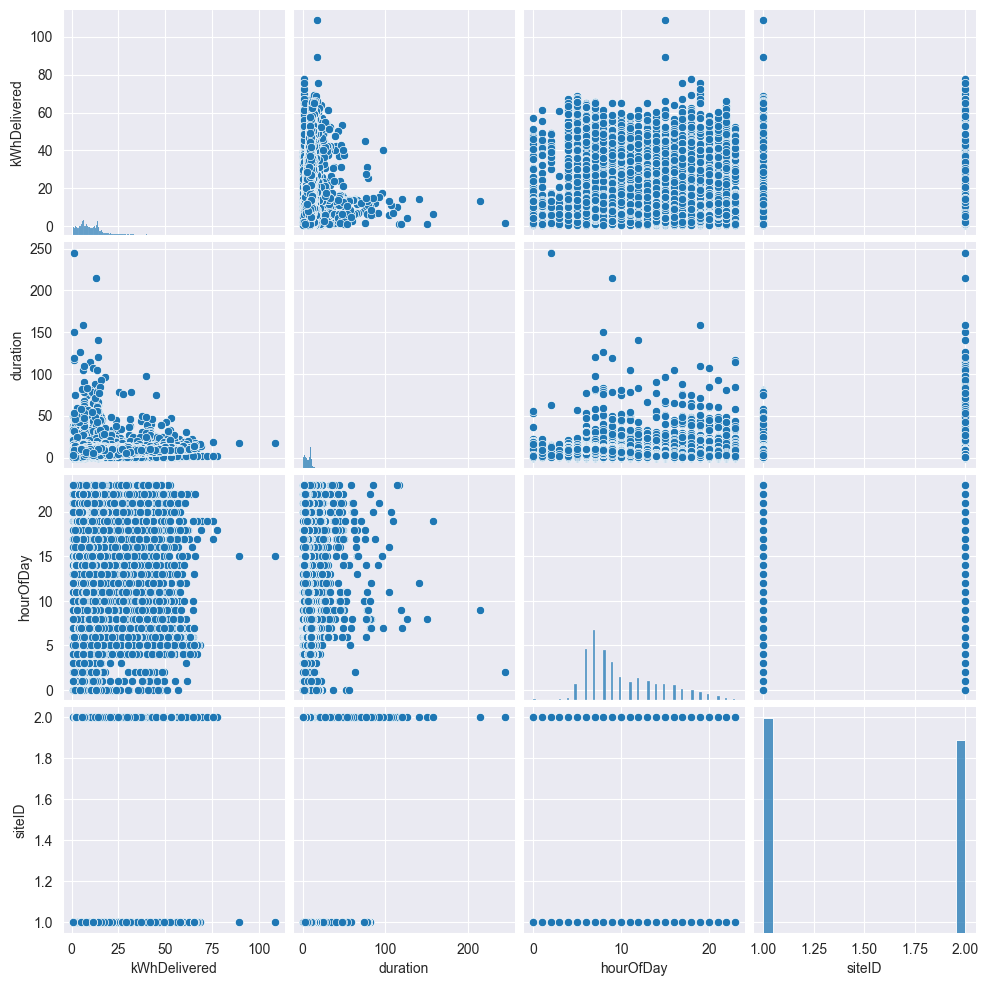

In [4]:
# Pairplot erstellen
sns.pairplot(data=features)

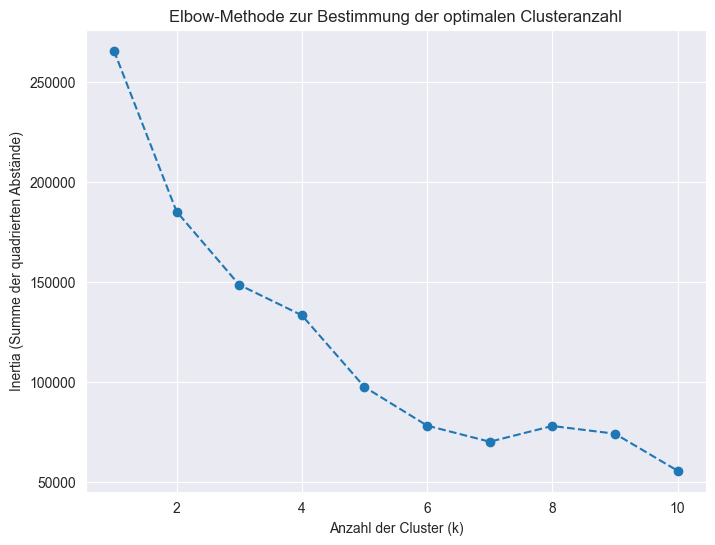

In [5]:
# 4. Daten normalisieren
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# 5. Elbow-Methode zur Bestimmung der optimalen Anzahl von Clustern
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusteranzahl")
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Summe der quadrierten Abstände)")
plt.grid(True)
plt.show()

In [6]:
# Determine the optimal number of clusters using silhouette score
best_score = -1
best_k = 0
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    score = silhouette_score(scaled_features, cluster_labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Best silhouette score: {best_score:.2f} with {best_k} clusters")

Best silhouette score: 0.43 with 7 clusters


In [7]:
# 6. Clusteranalyse mit der optimalen Anzahl von Clustern
# Benutzer kann die optimale Anzahl der Cluster auswählen
optimal_k = best_k #int(input("Gib die optimale Anzahl der Cluster (k) ein: "))
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster-Zentren zurückskalieren
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Cluster-Zentren ausgeben
print(f"\nCluster-Zentren ({optimal_k} Cluster):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i + 1}:")
    print(f"  Gelieferte Energie = {center[0]:.2f} kWh")
    print(f"  Ladezeit = {center[1]:.2f} Stunden")
    print(f"  Stunde des Tages = {center[2]:.2f}")
    print(f"  Standort-ID = {center[3]:.2f}")
    print()


Cluster-Zentren (7 Cluster):
Cluster 1:
  Gelieferte Energie = 18.41 kWh
  Ladezeit = 15.28 Stunden
  Stunde des Tages = 18.57
  Standort-ID = 1.99

Cluster 2:
  Gelieferte Energie = 9.29 kWh
  Ladezeit = 3.21 Stunden
  Stunde des Tages = 13.66
  Standort-ID = 1.00

Cluster 3:
  Gelieferte Energie = 35.72 kWh
  Ladezeit = 8.38 Stunden
  Stunde des Tages = 7.75
  Standort-ID = 1.15

Cluster 4:
  Gelieferte Energie = 8.15 kWh
  Ladezeit = 6.54 Stunden
  Stunde des Tages = 8.76
  Standort-ID = 2.00

Cluster 5:
  Gelieferte Energie = 7.11 kWh
  Ladezeit = 2.12 Stunden
  Stunde des Tages = 16.07
  Standort-ID = 2.00

Cluster 6:
  Gelieferte Energie = 10.40 kWh
  Ladezeit = 8.16 Stunden
  Stunde des Tages = 6.67
  Standort-ID = 1.00

Cluster 7:
  Gelieferte Energie = 12.06 kWh
  Ladezeit = 71.55 Stunden
  Stunde des Tages = 13.77
  Standort-ID = 1.88



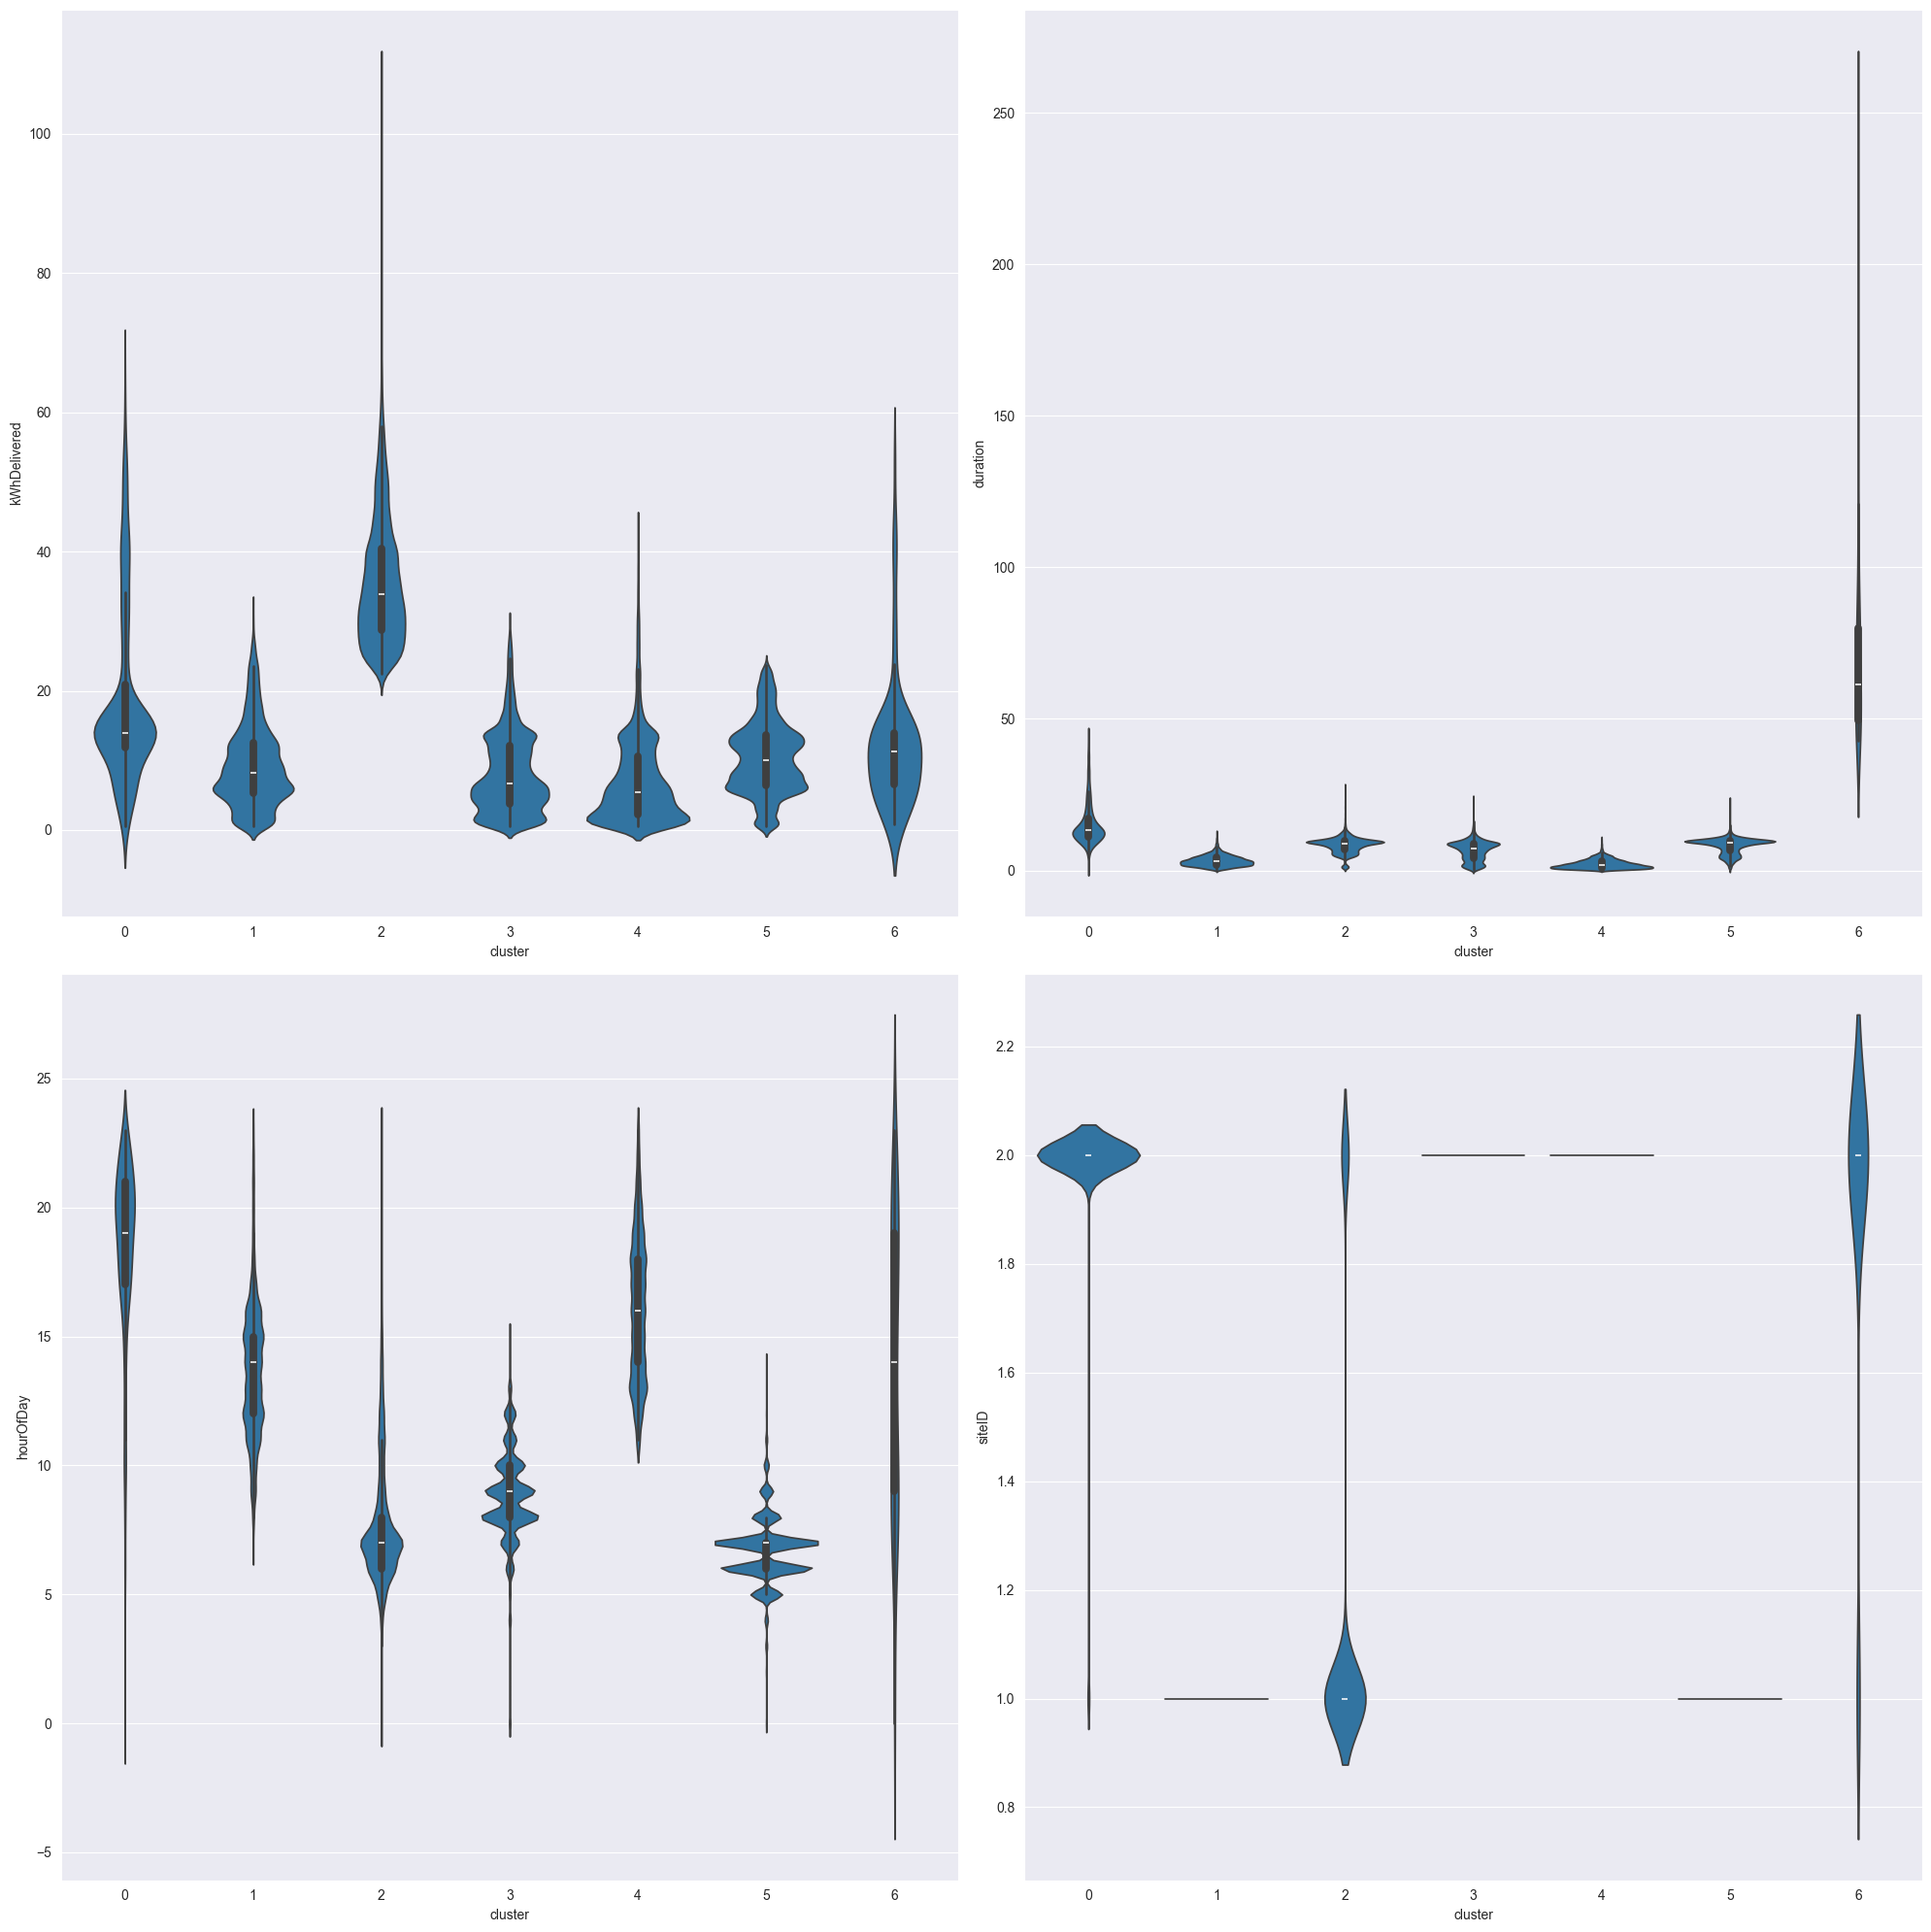

In [12]:
fig, axs = plt.subplots((len(features.columns)) // 2, 2)
fig.set_size_inches(20, 20)
for i, col in enumerate(features.columns):
    if col != "cluster":
        sns.violinplot(
            x=features['cluster'],
            y=features[col],
            ax=axs[i//2][i%2],
            data=features,
        )
plt.tight_layout()
plt.savefig("../output/cluster_analysis.png", format="png", dpi=300)

In [9]:
cluster_size = features.groupby('cluster').size()
cluster_size

cluster
0     1485
1     9926
2     6602
3    18182
4    10700
5    19441
6      112
dtype: int64

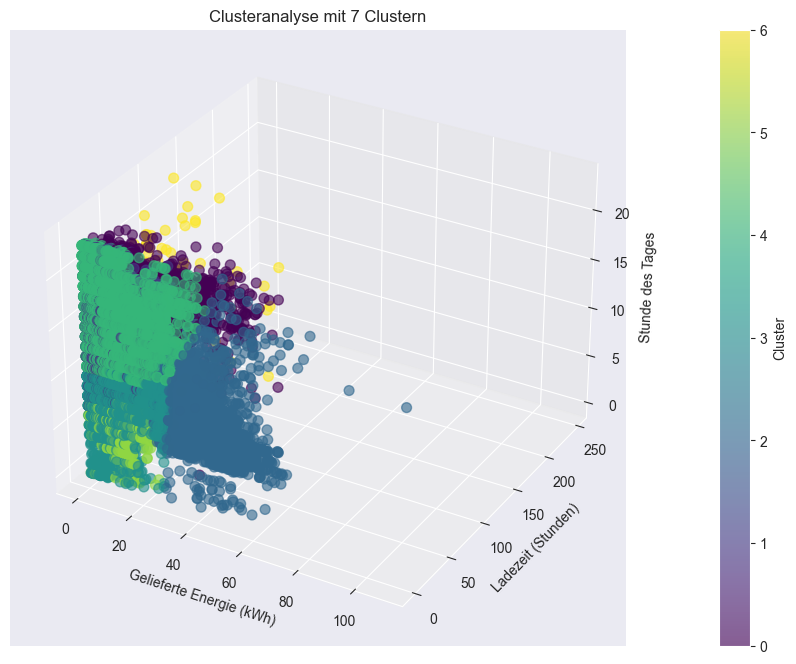

In [10]:
# 7. Grafische Darstellung der Clusteranalyse
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    features['kWhDelivered'],
    features['duration'],
    features['hourOfDay'],
    c=features['cluster'], cmap='viridis', s=50, alpha=0.6
)

# Achsen beschriften
ax.set_xlabel("Gelieferte Energie (kWh)")
ax.set_ylabel("Ladezeit (Stunden)")
ax.set_zlabel("Stunde des Tages")
ax.set_title(f"Clusteranalyse mit {optimal_k} Clustern")

# Farbskala hinzufügen
cbar = plt.colorbar(scatter, pad=0.1, ax=ax)
cbar.set_label("Cluster")

plt.show()